# Crypto Balance Statement Generator

This notebook processes cryptocurrency transaction data from a CSV file and generates a professional PDF balance report.

## Features:
- Process transaction data (inputs, outputs)
- Calculate current balances for each asset
- Generate summary statistics
- Create a beautiful PDF report with charts and tables

## CSV Format Expected:
The CSV should have columns: `date`, `asset`, `type`, `amount`, `price_usd`, `price_jpy`, `txn_url`
- **date**: Transaction date (MM/DD/YY HH:MM:SS format, e.g., 04/08/24 03:45:39)
- **asset**: Cryptocurrency symbol (BTC, ETH, etc.)
- **type**: Transaction type ('input' or 'output')
- **amount**: Amount of crypto (always positive, direction determined by type)
- **price_usd**: USD price per unit
- **price_jpy**: JPY price per unit  
- **txn_url**: Transaction URL (optional, for reference)

In [267]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, A4
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
import io
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Report generation date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Report generation date: 2025-07-23 23:35:18


In [268]:
# Configuration
CSV_FILE_PATH = "crypto_transactions.csv"  # Update this path to your CSV file
OUTPUT_PDF_PATH = "crypto_balance_report.pdf"

try:
    # First, let's try to detect the separator automatically
    import csv
    
    df = pd.read_csv(CSV_FILE_PATH, sep=",", encoding="utf-8")
    
    print(f"📂 Loaded existing CSV: {CSV_FILE_PATH}")
    
except FileNotFoundError:
    print(f"⚠️  CSV file not found. Creating sample data...")
    df = create_sample_csv()
except Exception as e:
    print(f"❌ Error loading CSV: {e}")

print(f"📊 Dataset shape: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")

# Display first few rows to verify the structure
if len(df.columns) == 1:
    print("⚠️ Warning: Data appears to be in a single column. Please check your CSV format.")
    print("First few values:")
    print(df.head())
else:
    df.head()

📂 Loaded existing CSV: crypto_transactions.csv
📊 Dataset shape: (49, 7)
📋 Columns: ['date', 'asset', 'type', 'amount', 'price_usd', 'price_jpy', 'txn_url']


In [269]:
# Data Processing and Validation
def process_transaction_data(df):
    """Process and validate transaction data"""
    
    # Make a copy to avoid modifying original
    df_processed = df.copy()
    
    # Check if we have the expected columns
    expected_columns = ['date', 'asset', 'type', 'amount', 'price_usd', 'price_jpy', 'txn_url']
    missing_columns = [col for col in expected_columns if col not in df_processed.columns]
    
    if missing_columns:
        print(f"❌ Missing columns: {missing_columns}")
        print(f"📋 Available columns: {list(df_processed.columns)}")
        raise ValueError(f"CSV is missing required columns: {missing_columns}")
    
    # Convert date column to datetime - try multiple formats
    date_formats = [
        '%m/%d/%y %H:%M:%S',  # MM/DD/YY HH:MM:SS (US format)
        '%d/%m/%y %H:%M:%S',  # DD/MM/YY HH:MM:SS (European format)
        '%Y-%m-%d %H:%M:%S',  # YYYY-MM-DD HH:MM:SS
        '%m/%d/%Y %H:%M:%S',  # MM/DD/YYYY HH:MM:SS
        '%d/%m/%Y %H:%M:%S',  # DD/MM/YYYY HH:MM:SS
    ]
    
    date_parsed = False
    for date_format in date_formats:
        try:
            df_processed['date'] = pd.to_datetime(df_processed['date'], format=date_format)
            print(f"✅ Successfully parsed dates with format: {date_format}")
            date_parsed = True
            break
        except (ValueError, TypeError):
            continue
    
    if not date_parsed:
        # Try pandas' automatic date parsing as fallback
        try:
            df_processed['date'] = pd.to_datetime(df_processed['date'], infer_datetime_format=True)
            print("✅ Successfully parsed dates with automatic detection")
        except Exception as e:
            print(f"❌ Could not parse dates: {e}")
            print(f"Sample date values: {df_processed['date'].head().tolist()}")
            raise
    
    # Ensure numeric columns are properly typed
    df_processed['amount'] = pd.to_numeric(df_processed['amount'], errors='coerce')
    df_processed['price_usd'] = pd.to_numeric(df_processed['price_usd'], errors='coerce')
    df_processed['price_jpy'] = pd.to_numeric(df_processed['price_jpy'], errors='coerce')
    
    # Check for any conversion issues
    if df_processed['amount'].isna().any():
        print("⚠️ Warning: Some amount values could not be converted to numbers")
    
    # Normalize transaction types to match new format
    type_mapping = {
        'input': 'input',
        'in': 'input',
        'deposit': 'input',
        'buy': 'input',
        'purchase': 'input',
        'output': 'output',
        'out': 'output',
        'withdrawal': 'output',
        'sell': 'output',
        'sale': 'output'
    }
    
    df_processed['type'] = df_processed['type'].str.lower().map(type_mapping)
    
    # Check for unmapped transaction types
    unmapped_types = df_processed[df_processed['type'].isna()]
    if len(unmapped_types) > 0:
        print(f"⚠️ Warning: {len(unmapped_types)} transactions have unmapped types:")
        print(unmapped_types[['date', 'asset', 'type']].head())
    
    # Handle amount signs based on transaction type
    # Input = positive (adding to balance), Output = negative (removing from balance)
    df_processed['signed_amount'] = df_processed.apply(
        lambda row: abs(row['amount']) if row['type'] == 'input' 
        else -abs(row['amount']), axis=1
    )
    
    # Calculate USD and JPY values
    df_processed['usd_value'] = df_processed['signed_amount'] * df_processed['price_usd'].fillna(0)
    df_processed['jpy_value'] = df_processed['signed_amount'] * df_processed['price_jpy'].fillna(0)
    
    # Sort by date
    df_processed = df_processed.sort_values('date').reset_index(drop=True)
    
    return df_processed

# Process the data
try:
    df_processed = process_transaction_data(df)
    
    print("🔄 Data processing complete!")
    print(f"📅 Date range: {df_processed['date'].min().strftime('%Y-%m-%d %H:%M')} to {df_processed['date'].max().strftime('%Y-%m-%d %H:%M')}")
    print(f"🪙 Assets: {', '.join(sorted(df_processed['asset'].unique()))}")
    print(f"📈 Transaction types: {', '.join(sorted(df_processed['type'].unique()))}")
    
    # Display processed data
    df_processed.head(10)
    
except Exception as e:
    print(f"❌ Error processing data: {e}")
    print("Please check your CSV format and try again.")

✅ Successfully parsed dates with automatic detection
🔄 Data processing complete!
📅 Date range: 2021-07-14 03:17 to 2024-12-12 04:13
🪙 Assets: Algo, Cake, TMPOOL2
📈 Transaction types: input, output


In [270]:
# Calculate Current Balances
def calculate_balances(df_processed):
    """Calculate current balances for each asset"""
    
    # Group by asset and sum the signed amounts
    balance_summary = df_processed.groupby('asset').agg({
        'signed_amount': 'sum',
        'usd_value': 'sum',
        'jpy_value': 'sum',
        'date': ['min', 'max'],
        'type': 'count'
    }).round(8)
    
    # Flatten column names
    balance_summary.columns = ['total_amount', 'total_usd_value', 'total_jpy_value', 'first_transaction', 'last_transaction', 'transaction_count']
    
    # Calculate average prices (weighted by transaction value)
    avg_prices_usd = df_processed.groupby('asset').apply(
        lambda x: (x['usd_value'].abs() / x['signed_amount'].abs().replace(0, np.nan)).mean()
    ).fillna(0)
    
    avg_prices_jpy = df_processed.groupby('asset').apply(
        lambda x: (x['jpy_value'].abs() / x['signed_amount'].abs().replace(0, np.nan)).mean()
    ).fillna(0)
    
    balance_summary['avg_price_usd'] = avg_prices_usd
    balance_summary['avg_price_jpy'] = avg_prices_jpy
    
    # Only keep assets with positive balances
    balance_summary = balance_summary[balance_summary['total_amount'] > 0].copy()
    
    # Sort by USD value (descending)
    balance_summary = balance_summary.sort_values('total_usd_value', ascending=False)
    
    return balance_summary

# Calculate balances
balances = calculate_balances(df_processed)

# Display summary statistics
total_portfolio_value_usd = balances['total_usd_value'].sum()
total_portfolio_value_jpy = balances['total_jpy_value'].sum()
num_assets = len(balances)
total_transactions = len(df_processed)

print("💰 PORTFOLIO SUMMARY")
print("=" * 50)
print(f"Total Portfolio Value (USD): ${total_portfolio_value_usd:,.2f}")
print(f"Total Portfolio Value (JPY): ¥{total_portfolio_value_jpy:,.0f}")
print(f"Number of Assets: {num_assets}")
print(f"Total Transactions: {total_transactions}")
print(f"Report Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n📊 CURRENT BALANCES:")
print("=" * 80)

# Format and display balances
for asset, row in balances.iterrows():
    print(f"{asset:>6}: {row['total_amount']:>12.6f} | ${row['total_usd_value']:>10,.2f} | ¥{row['total_jpy_value']:>12,.0f} | Avg USD: ${row['avg_price_usd']:>8,.2f}")

balances

💰 PORTFOLIO SUMMARY
Total Portfolio Value (USD): $11,252.00
Total Portfolio Value (JPY): ¥1,650,031
Number of Assets: 3
Total Transactions: 49
Report Date: 2025-07-23 23:35:18

📊 CURRENT BALANCES:
TMPOOL2:  6110.960000 | $  9,594.21 | ¥   1,406,926 | Avg USD: $    1.57
  Cake:   384.280000 | $  1,077.03 | ¥     157,940 | Avg USD: $    2.81
  Algo:  2074.160000 | $    580.76 | ¥      85,165 | Avg USD: $    0.28


,total_amount,total_usd_value,total_jpy_value,first_transaction,last_transaction,transaction_count,avg_price_usd,avg_price_jpy
asset,,,,,,,,
TMPOOL2,6110.96,9594.2072,1.406926e+06,2023-01-23 19:10:16,2023-01-23 19:22:43,2,1.570000,230.230000
Cake,384.28,1077.0268,1.579397e+05,2021-07-14 03:17:06,2024-12-12 04:13:47,29,2.814828,412.777931
Algo,2074.16,580.7648,8.516501e+04,2022-07-09 05:47:43,2024-08-04 03:45:39,18,0.280000,41.060000


✅ Registered NotoSansJP font for PDF generation
📊 Creating visualizations...


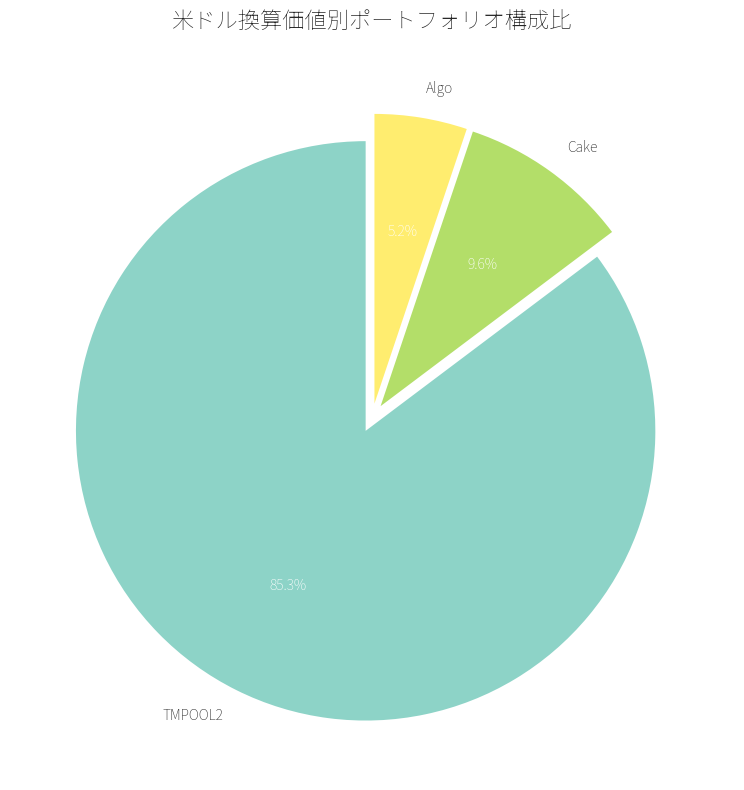

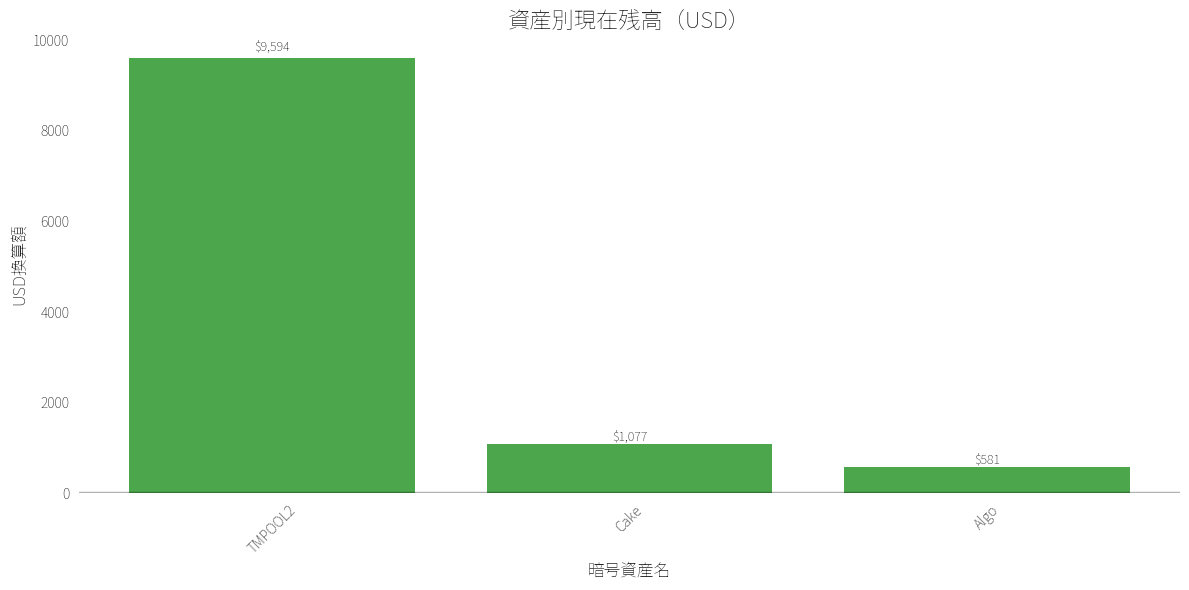

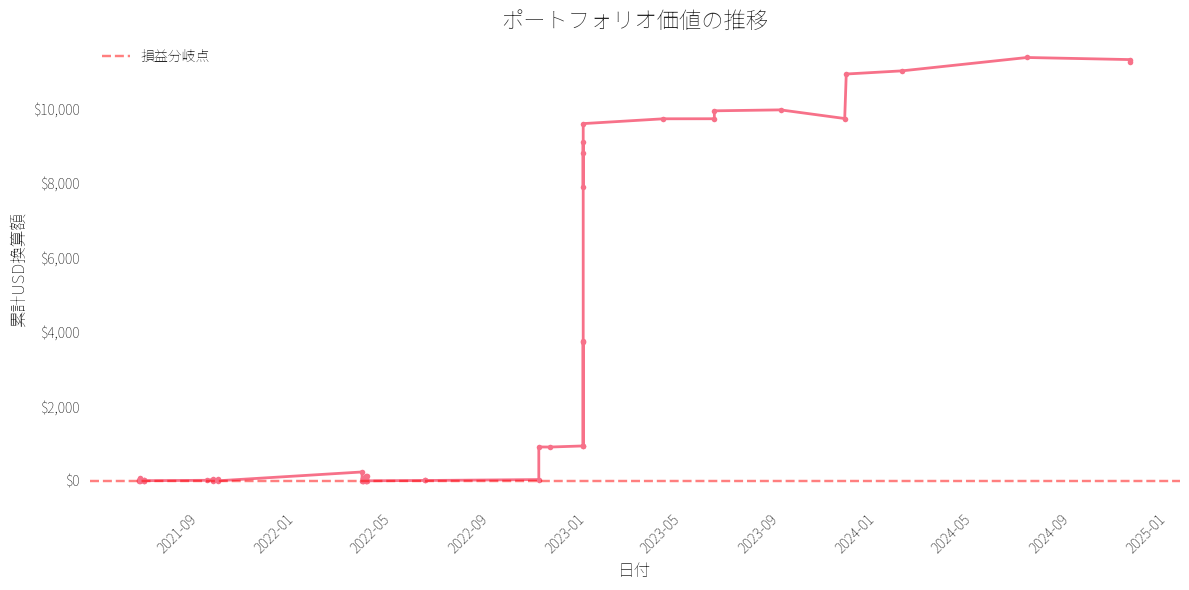

✅ Visualizations created successfully!


In [271]:
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase.cidfonts import UnicodeCIDFont
import matplotlib
from matplotlib import font_manager
font_manager.fontManager.addfont('NotoSansJP-VariableFont_wght.ttf')
matplotlib.rcParams['font.family'] = 'Noto Sans JP'

pdfmetrics.registerFont(TTFont('NotoSansJP', 'NotoSansJP-VariableFont_wght.ttf'))
print("✅ Registered NotoSansJP font for PDF generation")

# Create Visualizations
def create_visualizations(balances, df_processed):
    """Create charts for the PDF report"""
    
    # Set up the plotting style
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Filter to only positive balances for visualizations
    positive_balances = balances[balances['total_usd_value'] > 0].copy()
    
    if len(positive_balances) == 0:
        print("⚠️ Warning: No positive balances found for visualization")
        # Create empty placeholder charts
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.text(0.5, 0.5, '表示可能な正の残高がありません', 
                ha='center', va='center', fontsize=16, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        plt.tight_layout()
        
        # Save placeholder
        pie_chart_path = 'portfolio_allocation.png'
        bar_chart_path = 'balance_by_asset.png'
        timeline_chart_path = 'portfolio_timeline.png'
        
        plt.savefig(pie_chart_path, dpi=300, bbox_inches='tight')
        plt.savefig(bar_chart_path, dpi=300, bbox_inches='tight')
        plt.savefig(timeline_chart_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return pie_chart_path, bar_chart_path, timeline_chart_path
    
    # 1. Portfolio Allocation Pie Chart
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(positive_balances)))
    
    wedges, texts, autotexts = ax1.pie(
        positive_balances['total_usd_value'], 
        labels=positive_balances.index, 
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=[0.05] * len(positive_balances)
    )
    
    ax1.set_title('米ドル換算価値別ポートフォリオ構成比', fontsize=16, fontweight='bold', pad=20)
    
    # Beautify the pie chart
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    plt.tight_layout()
    
    # Save pie chart
    pie_chart_path = 'portfolio_allocation.png'
    plt.savefig(pie_chart_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Balance by Asset Bar Chart (show both positive and negative)
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    
    # Use all balances for the bar chart, but color differently
    bar_colors = ['green' if val > 0 else 'red' for val in balances['total_usd_value']]
    
    bars = ax2.bar(balances.index, balances['total_usd_value'], color=bar_colors, alpha=0.7)
    ax2.set_title('資産別現在残高（USD）', fontsize=16, fontweight='bold')
    ax2.set_xlabel('暗号資産名', fontsize=12)
    ax2.set_ylabel('USD換算額', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add a horizontal line at zero
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, balances['total_usd_value']):
        height = bar.get_height()
        label_y = height + (abs(height) * 0.01) if height >= 0 else height - (abs(height) * 0.01)
        ax2.text(bar.get_x() + bar.get_width()/2., label_y,
                f'${value:,.0f}', ha='center', va='bottom' if height >= 0 else 'top', 
                fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    
    # Save bar chart
    bar_chart_path = 'balance_by_asset.png'
    plt.savefig(bar_chart_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Transaction History Timeline
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    
    # Create cumulative USD value over time
    df_timeline = df_processed.sort_values('date').copy()
    df_timeline['cumulative_usd'] = df_timeline['usd_value'].cumsum()
    
    # Color the line based on positive/negative values
    ax3.plot(df_timeline['date'], df_timeline['cumulative_usd'], marker='o', linewidth=2, markersize=4)
    ax3.set_title('ポートフォリオ価値の推移', fontsize=16, fontweight='bold')
    ax3.set_xlabel('日付', fontsize=12)
    ax3.set_ylabel('累計USD換算額', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Add a horizontal line at zero
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='損益分岐点')
    
    # Format y-axis as currency
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add legend if there are negative values
    if df_timeline['cumulative_usd'].min() < 0:
        ax3.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save timeline chart
    timeline_chart_path = 'portfolio_timeline.png'
    plt.savefig(timeline_chart_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return pie_chart_path, bar_chart_path, timeline_chart_path

# Create all visualizations
print("📊 Creating visualizations...")
pie_path, bar_path, timeline_path = create_visualizations(balances, df_processed)
print("✅ Visualizations created successfully!")


In [ ]:
# Generate the Complete PDF Report
def generate_complete_report():
    """Generate the complete PDF report with all sections"""
    
    doc = SimpleDocTemplate(OUTPUT_PDF_PATH, pagesize=A4)
    story = []
    styles = getSampleStyleSheet()
    
    # Custom styles
    title_style = ParagraphStyle(
        'CustomTitle',
        fontName='NotoSansJP',
        parent=styles['Heading1'],
        fontSize=24,
        spaceAfter=30,
        textColor=colors.black,  # Changed to black
        alignment=1
    )
    
    subtitle_style = ParagraphStyle(
        'CustomSubtitle',
        fontName='NotoSansJP',
        parent=styles['Heading2'],
        fontSize=16,
        spaceAfter=20,
        textColor=colors.black,  # Changed to black
        alignment=1
    )
    
    section_style = ParagraphStyle(
        'SectionHeader',
        fontName='NotoSansJP',
        parent=styles['Heading2'],
        fontSize=14,
        spaceBefore=20,
        spaceAfter=10,
        textColor=colors.black  # Changed to black
    )

    jp_style = ParagraphStyle(
        'Japanese',
        fontName='NotoSansJP',
        fontSize=12,
    )
    
    # Title and metadata
    story.append(Paragraph("暗号資産ポートフォリオ", title_style))
    story.append(Paragraph("残高明細レポート", subtitle_style))
    story.append(Spacer(1, 30))
    
    # Summary metrics
    total_value_usd = balances['total_usd_value'].sum()
    total_value_jpy = balances['total_jpy_value'].sum()
    report_date = datetime.now().strftime('%B %d, %Y at %I:%M %p')
    
    metadata_data = [
        ['レポート作成日時：', report_date],
        ['ポートフォリオ総額（USD）：', f'${total_value_usd:,.2f}'],
        ['ポートフォリオ総額（JPY）：', f'¥{total_value_jpy:,.0f}'],
        ['保有資産数：', str(len(balances))],
        ['取引件数：', str(len(df_processed))],
        ['対象期間：', f"{df_processed['date'].min().strftime('%Y-%m-%d')} to {df_processed['date'].max().strftime('%Y-%m-%d')}"]
    ]
    
    metadata_table = Table(metadata_data, colWidths=[2.5*inch, 3*inch])
    metadata_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, -1), colors.whitesmoke),
        ('TEXTCOLOR', (0, 0), (-1, -1), colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (0, -1), 'NotoSansJP'),
        ('FONTNAME', (1, 0), (1, -1), 'NotoSansJP'),
        ('FONTSIZE', (0, 0), (-1, -1), 11),
        ('GRID', (0, 0), (-1, -1), 1, colors.lightgrey),
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ('LEFTPADDING', (0, 0), (-1, -1), 12),
        ('TOPPADDING', (0, 0), (-1, -1), 8),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 8),
    ]))
    
    story.append(metadata_table)
    story.append(Spacer(1, 40))
    
    # Portfolio allocation section
    story.append(Paragraph("ポートフォリオ配分", section_style))
    story.append(Spacer(1, 10))
    
    try:
        img1 = Image(pie_path, width=280, height=280)
        story.append(img1)
    except Exception as e:
        story.append(Paragraph(f"グラフを読み込めませんでした：{str(e)}", jp_style))
    
    story.append(Spacer(1, 30))
    
    # Balance table with both USD and JPY
    story.append(Paragraph("現在の資産残高", section_style))
    story.append(Spacer(1, 10))
    
    balance_data = [['資産', '数量', 'USD換算額', 'JPY換算額', '平均取得単価（USD）', '配分比率']]
    
    for asset, row in balances.iterrows():
        allocation_pct = (row['total_usd_value'] / total_value_usd) * 100
        balance_data.append([
            asset,
            f"{row['total_amount']:.6f}",
            f"${row['total_usd_value']:,.2f}",
            f"¥{row['total_jpy_value']:,.0f}",
            f"${row['avg_price_usd']:,.2f}",
            f"{allocation_pct:.1f}%"
        ])
    
    balance_table = Table(balance_data, colWidths=[0.8*inch, 1.1*inch, 1.1*inch, 1.1*inch, 0.9*inch, 0.8*inch])
    balance_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.black),  # Header row black
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'NotoSansJP'),
        ('FONTSIZE', (0, 0), (-1, 0), 10),
        ('FONTSIZE', (0, 1), (-1, -1), 9),
        ('BACKGROUND', (0, 1), (-1, -1), colors.whitesmoke),  # Table body neutral
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
        ('GRID', (0, 0), (-1, -1), 1, colors.lightgrey),
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ('TOPPADDING', (0, 0), (-1, -1), 5),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 5),
    ]))
    
    story.append(balance_table)
    story.append(Spacer(1, 30))

    # --- All Transactions Table with Clickable Links ---
    story.append(Paragraph("全取引一覧", section_style))
    story.append(Spacer(1, 10))
    
    # Prepare transaction table data
    txn_data = [['日付', '資産', '種別', '数量', 'USD換算額', 'JPY換算額', '表示']]  # Header
    for _, row in df_processed.iterrows():
        # Format date
        date_str = row['date'].strftime('%Y-%m-%d %H:%M') if hasattr(row['date'], 'strftime') else str(row['date'])
        # Format type
        type_str = row['type'].capitalize() if isinstance(row['type'], str) else str(row['type'])
        # Format link as clickable
        if pd.notnull(row['txn_url']) and str(row['txn_url']).startswith('http'):
            link = f'<link href="{row["txn_url"]}">取引を表示</link>'
            link_paragraph = Paragraph(link, jp_style)
        else:
            link_paragraph = Paragraph('-', jp_style)
        txn_data.append([
            date_str,
            row['asset'],
            type_str,
            f"{row['amount']:.6f}",
            f"${row['amount']*row['price_usd']:,.2f}",
            f"¥{row['amount']*row['price_jpy']:,.0f}",
            link_paragraph
        ])
    
    txn_table = Table(txn_data, colWidths=[1.2*inch, 0.7*inch, 0.8*inch, 1*inch, 1*inch, 1*inch, 1.2*inch])
    txn_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.black),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'NotoSansJP'),
        ('FONTNAME', (0, 1), (-1, -1), 'NotoSansJP'),
        ('FONTSIZE', (0, 0), (-1, 0), 10),
        ('FONTSIZE', (0, 1), (-1, -1), 9),
        ('BACKGROUND', (0, 1), (-1, -1), colors.whitesmoke),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),
        ('GRID', (0, 0), (-1, -1), 1, colors.lightgrey),
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ('TOPPADDING', (0, 0), (-1, -1), 5),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 5),
    ]))
    story.append(txn_table)
    story.append(Spacer(1, 30))
    
    # Additional charts
    story.append(Paragraph("資産価値", section_style))
    try:
        img2 = Image(bar_path, width=500, height=250)
        story.append(img2)
    except:
        story.append(Paragraph("資産価値チャートを読み込めませんでした。", jp_style))
    
    story.append(Spacer(1, 20))
    
    story.append(Paragraph("ポートフォリオタイムライン", section_style))
    try:
        img3 = Image(timeline_path, width=500, height=250)
        story.append(img3)
    except:
        story.append(Paragraph("タイムラインチャートを読み込めませんでした。", styles['Normal']))
    
    # Build PDF
    doc.build(story)
    print(f"✅ PDF report generated successfully: {OUTPUT_PDF_PATH}")
    
# Generate the report
print("🚀 Generating PDF report...")
generate_complete_report()

# Display final summary
print("\n" + "="*60)
print("📋 REPORT GENERATION COMPLETE!")
print("="*60)
print(f"📄 PDF Report: {OUTPUT_PDF_PATH}")
print(f"💰 Total Portfolio Value (USD): ${balances['total_usd_value'].sum():,.2f}")
print(f"💴 Total Portfolio Value (JPY): ¥{balances['total_jpy_value'].sum():,.0f}")
print(f"🪙 Assets in Portfolio: {len(balances)}")
print(f"📊 Total Transactions Processed: {len(df_processed)}")
print(f"📅 Report Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)


🚀 Generating PDF report...
✅ PDF report generated successfully: crypto_balance_report.pdf

📋 REPORT GENERATION COMPLETE!
📄 PDF Report: crypto_balance_report.pdf
💰 Total Portfolio Value (USD): $11,252.00
💴 Total Portfolio Value (JPY): ¥1,650,031
🪙 Assets in Portfolio: 3
📊 Total Transactions Processed: 49
📅 Report Date: 2025-07-23 23:35:19


## 🎯 How to Use This Notebook

### Step 1: Prepare Your CSV File
Create a CSV file with your crypto transactions using this format:

```csv
date	asset	type	amount	price_usd	price_jpy	txn_url
04/08/24 03:45:39	BTC	input	0.5	42000	6300000	https://example.com/tx1
04/15/24 14:22:15	ETH	input	2.0	2500	375000	https://example.com/tx2
05/10/24 09:30:45	BTC	output	0.2	45000	6750000	https://example.com/tx3
05/20/24 16:15:33	ETH	input	1.0	2800	420000	https://example.com/tx4
```

**Column Descriptions:**
- `date`: Transaction date (MM/DD/YY HH:MM:SS format)
- `asset`: Crypto symbol (BTC, ETH, ADA, etc.)
- `type`: Transaction type ('input' for incoming, 'output' for outgoing)
- `amount`: Amount of crypto (always positive, direction determined by type)
- `price_usd`: USD price per unit
- `price_jpy`: JPY price per unit
- `txn_url`: Transaction URL (optional, for reference)

### Step 2: Update Configuration
In the configuration cell above, update:
- `CSV_FILE_PATH`: Path to your CSV file
- `OUTPUT_PDF_PATH`: Desired output PDF filename

### Step 3: Run All Cells
Execute all cells in order to:
1. Load and process your transaction data
2. Calculate current balances in both USD and JPY
3. Generate visualizations
4. Create a professional PDF report

### 📁 Output Files
- **PDF Report**: Comprehensive balance statement with charts and tables
- **Chart Images**: PNG files for portfolio allocation, asset values, and timeline

### 🔧 Customization Options
- Modify chart colors and styles in the visualization section
- Adjust PDF layout and styling in the PDF generation functions
- Add additional metrics or calculations as needed

### ⚠️ Notes
- The notebook creates sample data if no CSV file is found
- Input transactions add to your balance, output transactions subtract
- Zero or negative final balances are excluded from the report
- Both USD and JPY values are calculated and displayed
- The notebook supports both tab-separated and comma-separated CSV files
- Date format must be MM/DD/YY HH:MM:SS (e.g., 04/08/24 03:45:39)